In [1388]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta, date
import copy
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

В данном исследовании я буду использовать датасет ежедневного онлайна игроков игры Counter-Strike: Global Offensive (настольной версии) c момента альфа-тестирования игры (30 ноября 2011) по 18 ноября 2018. Данные были взяты с сайта Steam Database (https://steamdb.info/app/730/graphs/).

In [1389]:
data = pd.read_csv('csgo_stat.csv')

In [1390]:
print('head:\n', data.head(5))
print('\ntail:\n', data.tail(5))
print('\ninfo:\n')
print(data.info())
print('\ndescription\n', data.describe())
print('\nshape:', data.shape)

head:
          date  online
0  2011-11-30     680
1  2011-12-01       0
2  2011-12-02       0
3  2011-12-03       0
4  2011-12-04       0

tail:
             date  online
2541  2018-11-14  474959
2542  2018-11-15  480043
2543  2018-11-16  516851
2544  2018-11-17  546192
2545  2018-11-18  543916

info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 2 columns):
date      2546 non-null object
online    2546 non-null int64
dtypes: int64(1), object(1)
memory usage: 39.9+ KB
None

description
               online
count    2546.000000
mean   331913.393166
std    258019.055981
min         0.000000
25%     35040.500000
50%    399298.000000
75%    571156.500000
max    850485.000000

shape: (2546, 2)


#### Целями исследования данных являются:

1) Выявление сезонности количества игроков.

2) Обнаружение закономерностей в количестве игроков в зависимости от времен года.

3) Попытка предсказания популярности игры в будущем.

 ## Предобработка

В таблице всего 2 столбца: дата и количество игроков в этот день, так что структуру столбцов никак изменять не нужно. 

In [1391]:
data.date = pd.to_datetime(data.date,format='%Y-%m-%d') 
data.index = data.date

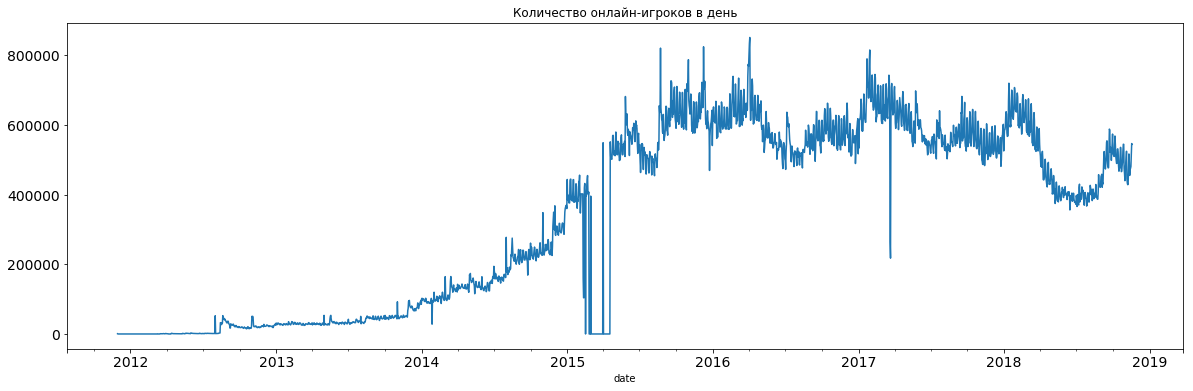

In [1392]:
data.online[:].plot( figsize=(20,6),title= 'Количество онлайн-игроков в день', fontsize=14)

Видно, что данных онлайн-статистики игроков до момента финального релиза игры (21 августа 2012) практически нет, так что эту часть данных можно просто выбросить.

In [1393]:
diff = (date(2012, 8, 21) - date(2011, 11, 30)).days
data = data.iloc[diff:]

Рассмотрим поближе участок в начале 2015 года, на котором отсутствуют данные.

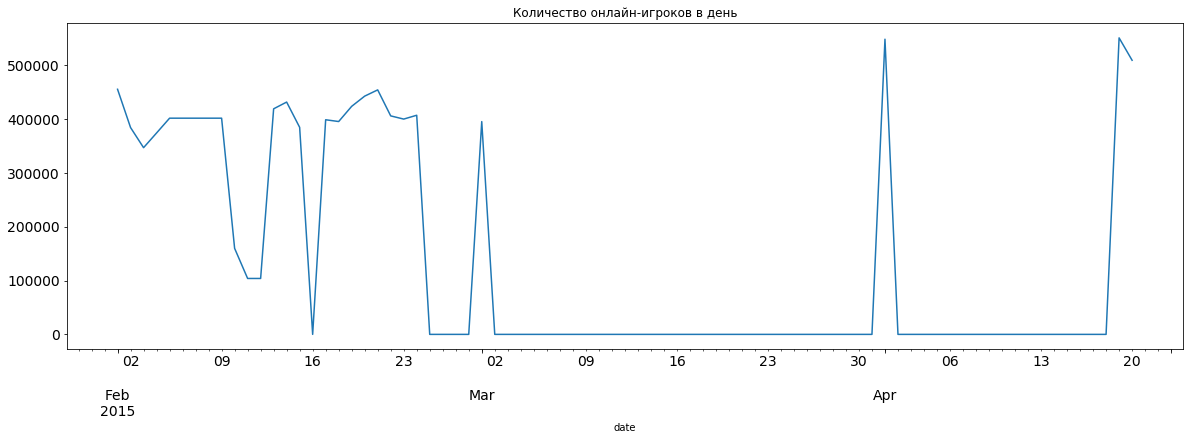

In [1394]:
temp = data.loc['2015-02-01':'2015-04-20']
temp.online.plot( figsize=(20,6),title= 'Количество онлайн-игроков в день', fontsize=14)

Видим, что в период с 16 февраля 2015 года по 20 апреля 2015 года данные об онлайне игроков отсутствуют. Обыкновенный гуглинг показывает, что никаких новостей об остановке серверов игры нет, также отсутствуют жалобы игроков. К тому же, в данный период проходили турниры по игре, в том числе мажорные. Следовательно, отсутствие данных на данном промежутке скорее объясняется сбоями работы сервиса Steam Database или проблемами работы SteamAPI, нежели неработоспособностью серверов игры.

Для удобства заполним пустые промежутки вычисленными линейно данными.

In [1395]:
head_i = 0
size = data.shape[0]
last_online = 0
while head_i < size:
    if data.online[head_i] == 0:
        tail_i = head_i + 1
        while tail_i < size and data.online[tail_i] == 0:
            tail_i += 1
        count_zeroes = tail_i - head_i
        d = (data.online[tail_i] - last_online)/(count_zeroes + 1)
        fill = [last_online + i * d for i in range(count_zeroes)]
        data.online[head_i:tail_i] = fill
    last_online = data.online[head_i]
    head_i += 1

Посмотрим на итоговый результат.

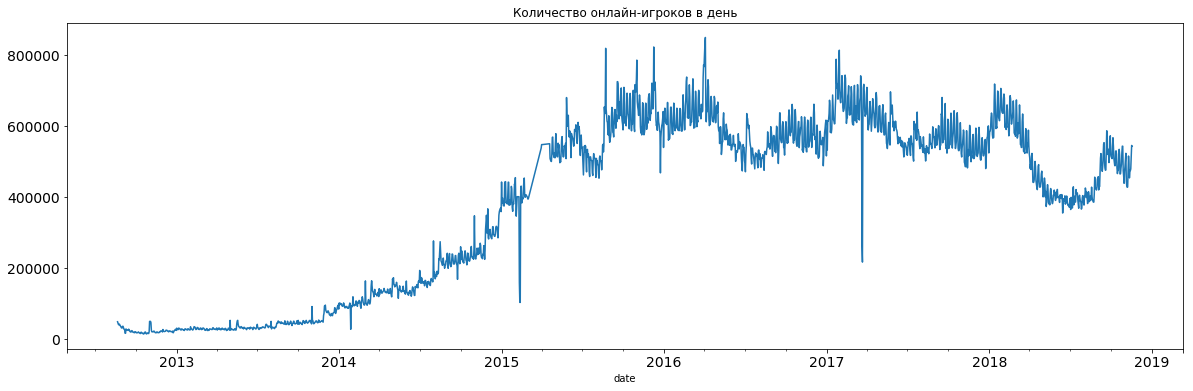

In [1396]:
data.online.plot( figsize=(20,6),title= 'Количество онлайн-игроков в день', fontsize=14)

## Исследование

Построим STL-декомпозицию

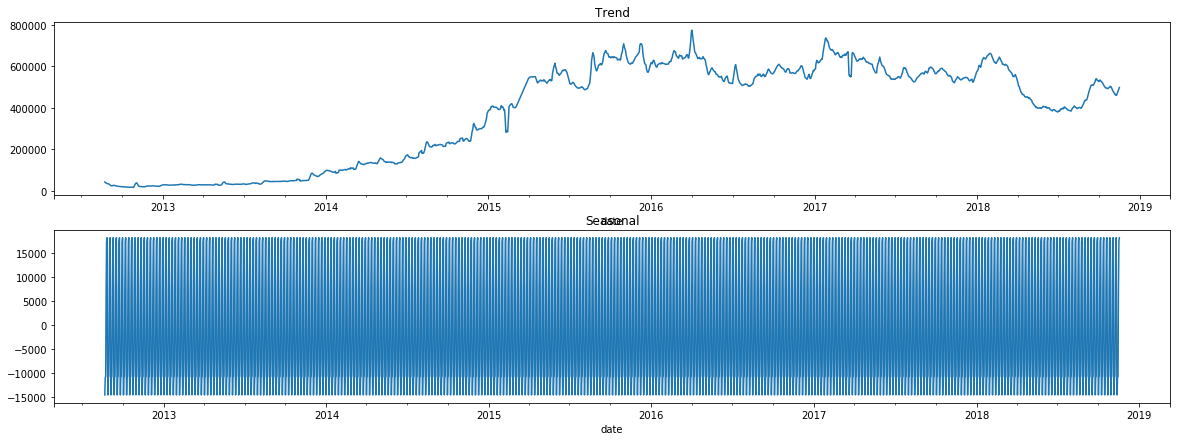

In [1397]:
rcParams['figure.figsize'] = 20, 7
components = sm.tsa.seasonal_decompose(data.online)
plt.subplot(211)
components.trend.plot(title= 'Trend')
plt.subplot(212)
components.seasonal.plot(title= 'Seasonal')
plt.show()

По данному графику сезонности не очень ясна её переодичность, но предположительно период равен неделе. Проверим это предположение, отрисовав какой-нибудь небольшой кусок данных, например, последние 10 недель.

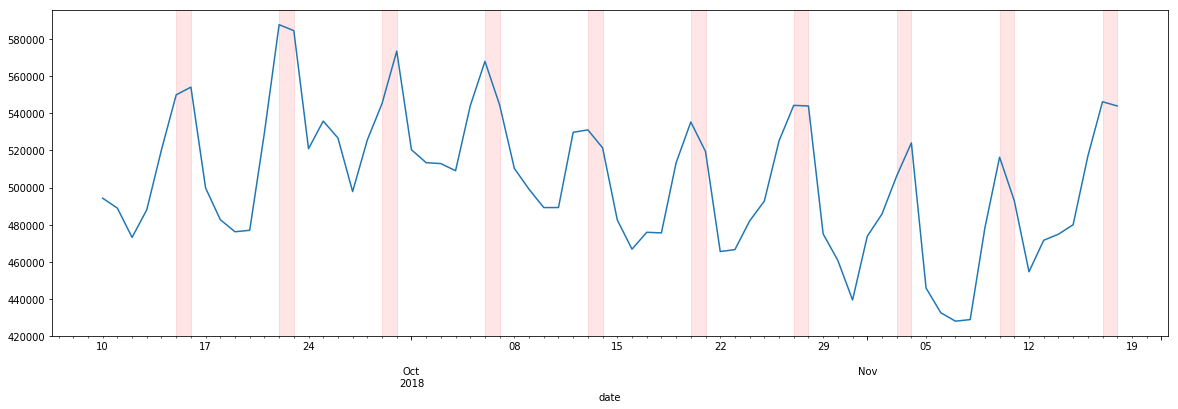

In [1398]:
data.online[-70:].plot(figsize=(20,6))
plt.axvspan('2018-09-15','2018-09-16' , color='red', alpha=0.1)
plt.axvspan('2018-09-22','2018-09-23' , color='red', alpha=0.1)
plt.axvspan('2018-09-29','2018-09-30' , color='red', alpha=0.1)
plt.axvspan('2018-10-06','2018-10-07' , color='red', alpha=0.1)
plt.axvspan('2018-10-13','2018-10-14' , color='red', alpha=0.1)
plt.axvspan('2018-10-20','2018-10-21' , color='red', alpha=0.1)
plt.axvspan('2018-10-27','2018-10-28' , color='red', alpha=0.1)
plt.axvspan('2018-11-03','2018-11-04' , color='red', alpha=0.1)
plt.axvspan('2018-11-10','2018-11-11' , color='red', alpha=0.1)
plt.axvspan('2018-11-17','2018-11-18' , color='red', alpha=0.1)

Красным цветом выделены суббота и воскресенье.

Действительно, хорошо видно наличие сезонности с периодом в 7 дней. При этом наибольшая активность игроков наблюдается в выходные, наименьшая - в середине недели.

Отрисуем данные с вычислением среднего количества онлайн-игроков по сезонам и выделением сезонов цветами:

лето - темно-зелёный, осень - оранжевый, зима - синий, весна - светло-зеленый

А также STL-декомпозицию с частотой 365 дней.

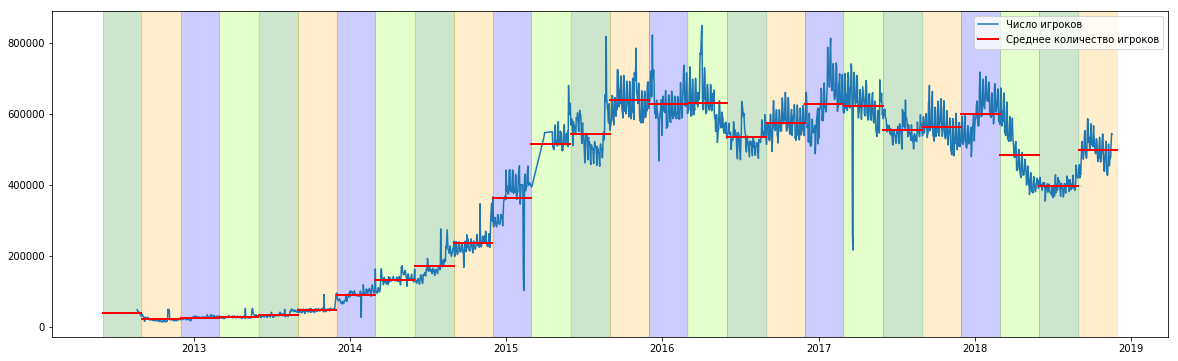

In [1399]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(111)
ax1.plot(data.online, label='Число игроков')

for i in range(6):
    winter = pd.date_range(start=str(2012 + i) + '-12-01', end=str(2013 + i) + '-02-28')
    spring = pd.date_range(start=str(2013 + i) + '-03-01', end=str(2013 + i) + '-05-31')
    summer = pd.date_range(start=str(2012 + i) + '-06-01', end=str(2012 + i) + '-08-31')
    autumn = pd.date_range(start=str(2012 + i) + '-09-01', end=str(2012 + i) + '-11-30')
    
    ax1.axvspan(summer[0], summer[-1] , color='green', alpha=0.2)
    ax1.axvspan(autumn[0], autumn[-1] , color='orange', alpha=0.2)
    ax1.axvspan(winter[0], winter[-1] , color='blue', alpha=0.2)
    ax1.axvspan(spring[0], spring[-1] , color='lawngreen', alpha=0.2)
    
    ax1.plot(summer, [data.online.loc[summer].mean()] * summer.shape[0], linewidth=2, color='red') 
    ax1.plot(autumn, [data.online.loc[autumn].mean()] * autumn.shape[0], linewidth=2, color='red')
    ax1.plot(winter, [data.online.loc[winter].mean()] * winter.shape[0], linewidth=2, color='red')
    ax1.plot(spring, [data.online.loc[spring].mean()] * spring.shape[0], linewidth=2, color='red')
    

    
summer = pd.date_range(start='2018-06-01', end='2018-08-31')
autumn = pd.date_range(start='2018-09-01', end='2018-11-30')
ax1.axvspan('2018-06-01','2018-08-31' , color='green', alpha=0.2)
ax1.axvspan('2018-09-01','2018-11-30' , color='orange', alpha=0.2)
   
ax1.plot(summer, [data.online.loc[summer].mean()] * summer.shape[0], linewidth=2, color='red') 
ax1.plot(autumn, [data.online.loc[autumn].mean()] * autumn.shape[0], linewidth=2, color='red', label='Среднее количество игроков')

ax1.legend(loc='best')
plt.show()

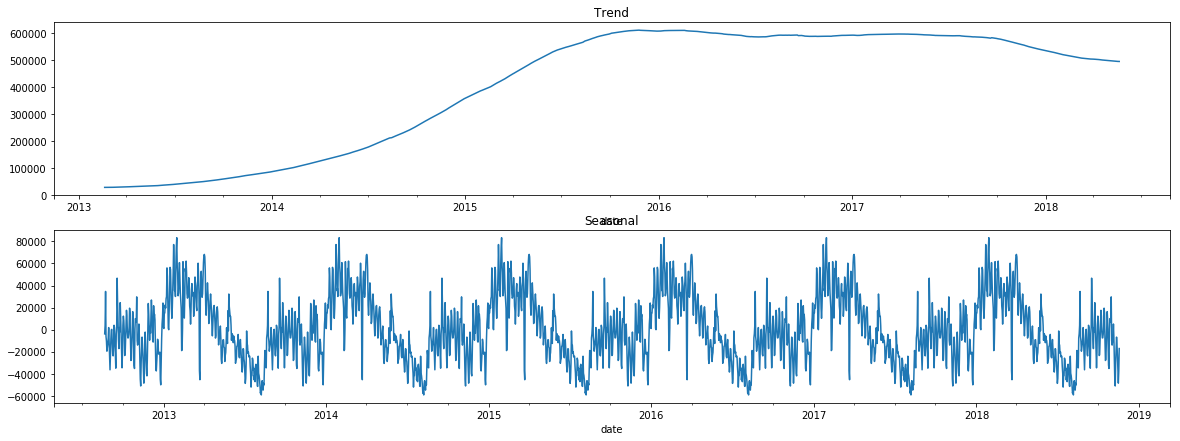

In [1400]:
rcParams['figure.figsize'] = 20, 7
components = sm.tsa.seasonal_decompose(data.online, freq=365)
plt.subplot(211)
components.trend.plot(title= 'Trend')
plt.subplot(212)
components.seasonal.plot(title= 'Seasonal')
plt.show()

По графику тренда можно заметить, что значительный рост количества игроков наблюдался до осени 2015 года. Далее, в период с осени 2015 года по весну 2017 года наблюдалась некоторая стабильность онлайн-игроков. И по итогу, с лета 2017 года по наше время наблюдается тендеция спада количества игроков, что объясняется обыкновенным снижением интереса к игре из-за отсутствия развития удерживающих факторов для игры разработчиками.



Также замечаем, что помимо недельной сезонности наблюдается сезонность по годам. Можно предположить, что летом в Counter-Strike: Global Offensive играет меньше людей, чем зимой. Это может быть связано, например, с тем, что в большинстве стран зимой люди чаще сидят дома из-за холодной погоды, чем летом.

Кстати, можно заметить сильные выбросы, например, в конце лета 2015 года, в начале зимы 2016, весной 2016 и т.д. В данные дни проводились мажорные (самые крупные) турниры по игре и раздача бонусов за их просмотр, что и обеспечило высокий онлайн игроков. Однако, сразу после турнира онлайн игроков резко падает, то есть, проведение мажоров ненадолго стимулирует игроков заходить в игру.

## Гипотезы

Отбросим период сильного роста и посмотрим на график распределения игроков в день.

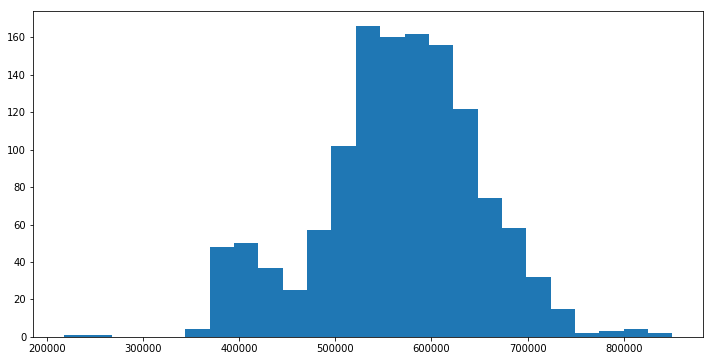

In [1401]:
rcParams['figure.figsize'] = 12, 6
plt.hist(data.iloc[1000:].online, 25)
plt.show()

Распределение онлайн-игроков во время относительной стабильности аудитории игры похоже на нормальное.

Сформулируем гипотезу: Количество игроков зимой равно количества игроков летом в среднем.

Возьмем период с 2015 по 2018, отбросив периоды сильного роста аудитории в начале, так как в этот период, очевидно, что это будет выполняться.

Same shapes?: True


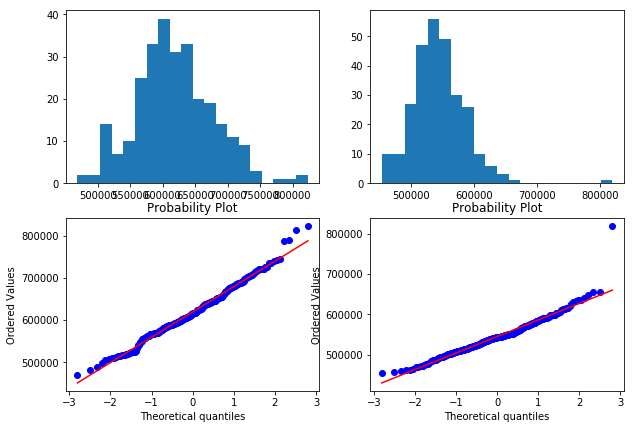

In [1402]:
data_winter = data['2015-12-01':'2016-03-01']
data_winter = data_winter.append(data['2016-12-01':'2017-03-02'])
data_winter = data_winter.append(data['2017-12-01':'2018-03-02'])
data_summer = data['2016-06-01':'2016-08-31']
data_summer = data_summer.append(data['2015-06-01':'2015-08-31'])
data_summer = data_summer.append(data['2017-06-01':'2017-08-31'])

print('Same shapes?:', data_winter.shape == data_summer.shape)

rcParams['figure.figsize'] = 10, 7
ax1 = plt.subplot(221)
ax1.hist(data_winter.online, 20)
ax2 = plt.subplot(222)
ax2.hist(data_summer.online, 20)

ax3 = plt.subplot(223)
stats.probplot(data_winter.online, dist = "norm", plot = plt)
ax4 = plt.subplot(224)
stats.probplot(data_summer.online, dist = "norm", plot = plt)

plt.show()

Графики показывают, что распределения количества игроков зимой и летом нормальные.

Воспользуемся т-криерием Стьюдента.

In [1403]:
stats.ttest_ind(data_winter.online, data_summer.online)

Ttest_indResult(statistic=16.850097076119255, pvalue=1.1316640106139687e-51)

По данному критерию pvalue 1.13 * 10^(-57), следовательно, гипотеза опровергнута, и количество игроков зимой в среднем отличается от количества игроков летом.

## Предсказание временного ряда

Теперь попробуем спрогнозировать поведение ряда.

Так как нам желательно предсказать количество игроков на довольно длительный период времени, то анализировать ежедневный онлайн будет не совсем верно из-за недельной сезонности и различия количества игроков в разные дни недели. К тому же обучение моделей будет происходить дольше. Поэтому предлагаю перейти от ежедневного к недельному интервалу, взяв среднее значение количества онлайн-игроков за неделю. 

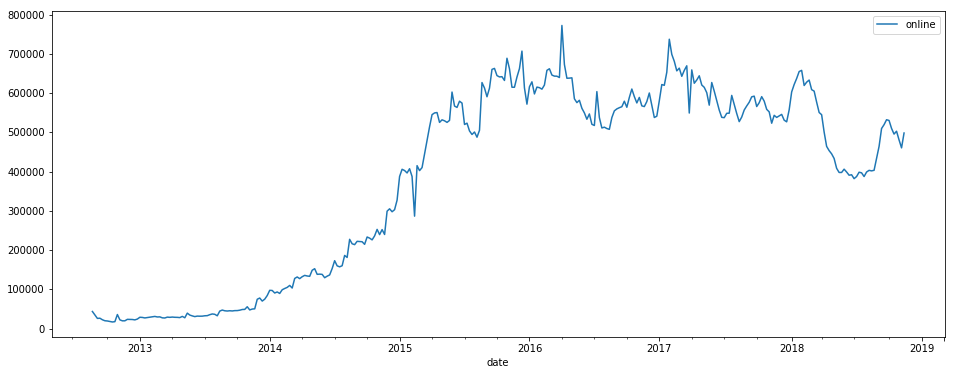

In [1404]:
data_week = data.resample('w', how='mean')
data_week.plot(figsize=(16,6))

Для предсказания будем использовать метод линейного тренда Холта-Уинтерса и экспоненциальное сглаживание с учетом сезонности.

Для начала разобъем выборку на тренировочную и тестовую.

In [1405]:
train = data_week.iloc[:-52]
test = data_week.iloc[-52:]

Теперь начнём перебор параметров. Для метода экспоненциального сглаживания с учетом сезонности выберем годичную сезонность (52 недели).

In [1406]:
best_holt_winter_rmse = None
best_holt_winter_fit = None
best_ss_hw = None
best_sl_hw = None

for sl in np.arange(0, 1, 0.1):
    for ss in np.arange(0, 1, 0.1):
        fit = ExponentialSmoothing(train.online.values, seasonal_periods=52, trend='add', seasonal='add')\
                                .fit(smoothing_level = sl, smoothing_slope = ss)
        y_pred = fit.forecast(len(test))
        rmse = mean_squared_error(test.online, y_pred)
        
        if (best_holt_winter_rmse is None) or (rmse < best_holt_winter_rmse):
            best_holt_winter_fit = fit
            best_holt_winter_rmse = rmse
            best_ss_hw = ss
            best_sl_hw = sl

In [1407]:
best_holt_linear_rmse = None
best_holt_linear_fit = None
best_ss_hl = None
best_sl_hl = None

for sl in np.arange(0, 1, 0.1):
    for ss in np.arange(0, 1, 0.1):
        fit = Holt(train.online.values).fit(smoothing_level = sl, smoothing_slope = ss)
        y_pred = fit.forecast(len(test))
        rmse = mean_squared_error(test.online, y_pred)
        
        if (best_holt_linear_rmse is None) or (rmse < best_holt_linear_rmse):
            best_holt_linear_fit = fit
            best_holt_linear_rmse = rmse
            best_ss_hl = ss
            best_sl_hl = sl

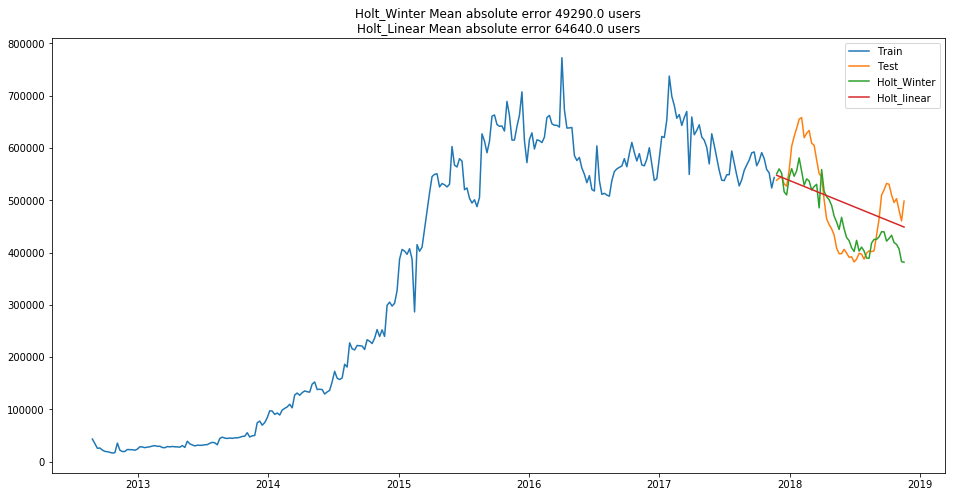

In [1408]:
y_pred = test.copy()
y_pred['Holt_Winter'] = best_holt_winter_fit.forecast(len(test))
y_pred['Holt_linear'] = best_holt_linear_fit.forecast(len(test))
y_pred['Sarima'] = best_holt_linear_fit.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train.online, label='Train')
plt.plot(test.online, label='Test')
plt.plot(y_pred['Holt_Winter'], label='Holt_Winter')
plt.plot(y_pred['Holt_linear'], label='Holt_linear')
plt.title("Holt_Winter Mean absolute error {} users\nHolt_Linear Mean absolute error {} users"\
            .format(round(mean_absolute_error(y_pred['Holt_Winter'], test.online.values)), 
                    round(mean_absolute_error(y_pred['Holt_linear'], test.online.values))))
plt.legend(loc='best')
plt.show()

Можно обнаружить, что метод экспоненциального сглаживание с учётом сезонности справился не так плохо, но не попал в два пика. Однако, этим можно пренебречь, так как во временной промежуток этих двух пиков проходили самые крупные турниры по CS:GO. Стоит отметить, что проводятся они несистематически, поэтому предсказать их не так просто.

Теперь попробуем предсказать ситуацию на год вперёд.

In [1409]:
holt_winter_fit = ExponentialSmoothing(data_week.online.values, seasonal_periods=52, trend='add', seasonal='add')\
                                .fit(smoothing_level = best_sl_hw, smoothing_slope = best_ss_hw)

holt_linear_fit = Holt(data_week.online.values).fit(smoothing_level = best_sl_hl, smoothing_slope = best_ss_hl)

In [1410]:
ind = test.index.values
diff = pd.to_datetime(ind[1]) - pd.to_datetime(ind[0])
ind = [pd.to_datetime(ind[-1])] * 52
for i in range(0, 52):
    ind[i] = pd.to_datetime(ind[i]) + (i + 1) * timedelta(weeks=1)

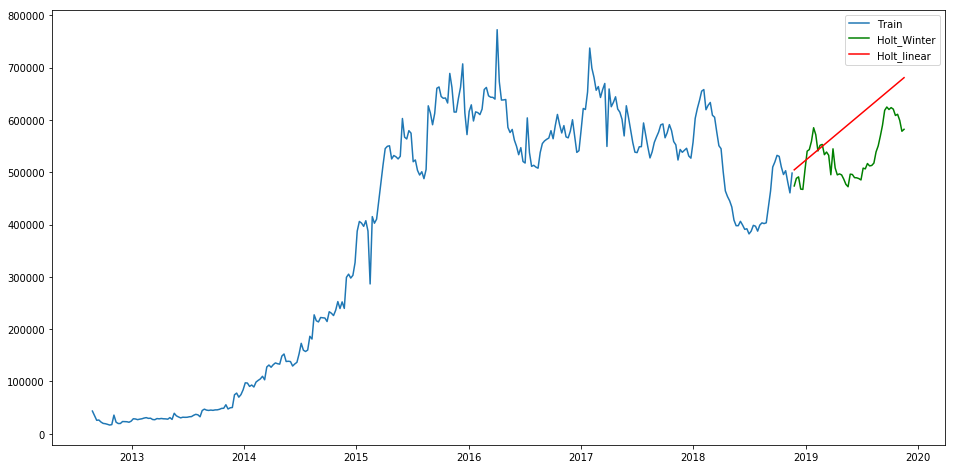

In [1411]:
y_pred = test.copy()
y_pred.index = ind
y_pred['Holt_Winter'] = holt_winter_fit.forecast(52)
y_pred['Holt_linear'] = holt_linear_fit.forecast(52)
plt.figure(figsize=(16,8))
plt.plot(data_week.online, label='Train')
plt.plot(y_pred['Holt_Winter'], label='Holt_Winter', color='g')
plt.plot(y_pred['Holt_linear'], label='Holt_linear', color='r')
plt.legend(loc='best')
plt.show()

Можно заметить, что метод экспоненциального сглаживания с учётом сезонности показал более правдоподобные результаты. Всё так же наблюдается совсем небольшой понижающий тренд. То есть, если разработчики игры и дальше будут продолжать игнорировать интересы аудитории, то снижение её аудитории, действительно, ожидаемо.

## Вывод

Мы провели анализ данных о количестве игроков популярной видеоигры Counter-Strike: Global Offensive и исследовали следующие вопросы:

1. Выявление сезонности количества игроков.

    -   Да, действительно, наблюдаются как дневная, так и годичная сезонности. 


2. Обнаружение закономерностей в количестве игроков в зависимости от времен года.

    - Закономерность прослеживается. От лета к зиме и наоборот прослеживаются четкий рост и спад количества игроков соответственно. Наибольшее количество геймеров наблюдается зимой, наименьшее же - летом.
    

3. Попытка предсказания популярности игры в будущем.

    - Наше предсказание количества игроков оказалось довольно близким к действительности. В данное время наблюдается тендеция спада аудитории игры в силу разных причин: неправильная политика поддержания игры разработчиками, появление новых популярых игр и отток к ним аудитории и т.д. И как показал наш прогноз, Counter-Strike будет и дальше терять свою популярность при неизменности сложившейся ситуации. 